In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
import time
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
df_train = pd.read_csv('BBC News Train.csv')
df_test = pd.read_csv('BBC News Test.csv')

In [3]:
df_train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
df_train.Category.value_counts()

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

<Axes: xlabel='Category'>

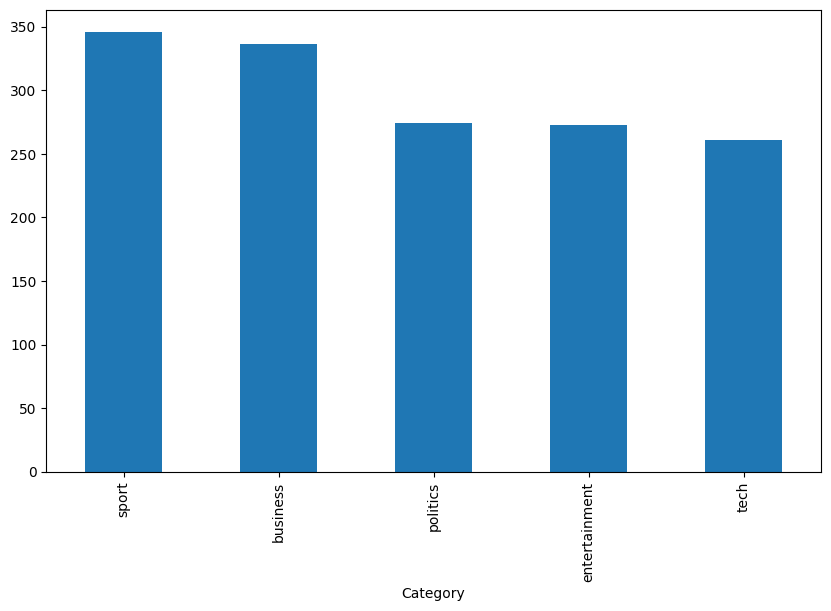

In [5]:
# distribution of categories
plt.figure(figsize=(10,6))
df_train.Category.value_counts().plot(kind='bar')


<Axes: xlabel='Category'>

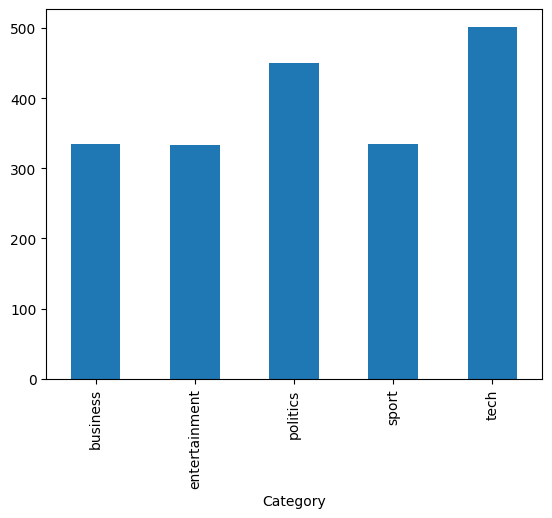

In [6]:
# word count per category
df_train['word_count'] = df_train['Text'].apply(lambda x: len(str(x).split()))
df_train.groupby('Category')['word_count'].mean().plot(kind='bar')

In [7]:
# top 20 popular words
cnt = Counter()
for text in df_train['Text'].values:
    for word in text.split():
        cnt[word] += 1

cnt.most_common(20)

[('the', 34992),
 ('to', 16568),
 ('of', 12970),
 ('and', 12366),
 ('a', 12102),
 ('in', 11696),
 ('s', 5899),
 ('for', 5773),
 ('is', 5478),
 ('that', 5207),
 ('it', 5000),
 ('on', 4991),
 ('was', 4019),
 ('he', 3866),
 ('be', 3803),
 ('with', 3482),
 ('said', 3401),
 ('has', 3250),
 ('as', 3245),
 ('have', 3133)]

Some takeaways from the EDA:
- categories are distributed relatively evenly
- the most common words are the so-called 'stop words'
which will be removed down below using the NLTK library as they don't provide useful information about the article

In [8]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/martin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/martin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
# text processing
# translator is used to remove punctuation and stop words such as 'the', 'a', 'an', 'in', 'on', etc. are removed
# source: https://www.geeksforgeeks.org/python-stemming-words-with-nltk/ https://www.geeksforgeeks.org/text-preprocessing-in-python-set-1/
translator = str.maketrans('', '', string.punctuation)
stop_words = set(stopwords.words('english'))

def process_text(text):
  text = text.lower()
  words = word_tokenize(text) 
  words = [word for word in words if not word in stop_words]
  stemmer= PorterStemmer()
  stem_text=' '.join([stemmer.stem(word.translate(translator)) for word in words])
  
  return stem_text

In [10]:
# apply the processing to the text
process_text(df_train.iloc[0].Text)
df_train['Processed'] = df_train['Text'].apply(process_text)

Now, we need to turn the text to matrix form (text vectorization). I have decided to go with tf-idf (term frequency–inverse document frequency). This method evaluates how useful a word is in a document by multiplying two metrics:
- how many times a word appears in a document
- the inverse document frequency of the word across a set of documents 
Once the text is transformed, it can be fed to a ML algorithm since TF-IDF enables us to associate each word in a document with a number that represents how relevant each word is in that document. Then, documents with similar, relevant words will have similar vectors.

source: https://monkeylearn.com/blog/what-is-tf-idf/

In [11]:
vect = TfidfVectorizer()
X = vect.fit_transform(df_train.Processed)
X.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02407628, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02546556, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [12]:
model = NMF(n_components=5, random_state=42)
W = model.fit_transform(X)
H = model.components_
print(W.shape)
print(H.shape)

(1490, 5)
(5, 19645)


In [13]:
# get an array of predicted labels and map labels to categories
labels = np.squeeze(np.asarray(W.argmax(axis=1)))
label_to_categ = {}
for i in range(5):
  label_to_categ[i] = df_train.iloc[np.where(labels == i)[0]]['Category'].value_counts().idxmax()

In [14]:
# test the accuracy of the model
predicted_categ = np.vectorize(label_to_categ.get)(labels)
print(accuracy_score(df_train.Category, predicted_categ))
confusion_matrix(df_train.Category, predicted_categ)

0.9194630872483222


array([[312,   1,  13,   0,  10],
       [ 10, 226,   6,   3,  28],
       [ 18,   0, 249,   3,   4],
       [  2,   4,   0, 340,   0],
       [  4,   6,   3,   5, 243]])

In [15]:
test_pred_categ = np.vectorize(label_to_categ.get)(model.transform(vect.transform(df_test['Text'].apply(process_text))).argmax(axis=1))

In [16]:
# I've decided to use KL divergence as beta_loss because it is more suitable for text data
model = NMF(n_components=5, random_state=42, solver = 'mu', beta_loss = 'kullback-leibler')
W = model.fit_transform(X)
labels = np.squeeze(np.asarray(W.argmax(axis=1)))
label_to_categ = {}
for i in range(5):
  label_to_categ[i] = df_train.iloc[np.where(labels == i)[0]]['Category'].value_counts().idxmax()

test_pred_categ = np.vectorize(label_to_categ.get)(model.transform(vect.transform(df_test['Text'].apply(process_text))).argmax(axis=1))
acc = accuracy_score(df_train.Category, np.vectorize(label_to_categ.get)(W.argmax(axis=1)))
print(f"NMF-KL accuracy: {acc} ")

NMF-KL accuracy: 0.9416107382550336 


In [17]:
# find the best min_df for NMF
for min_df in [10, 50, 100]:
  vect = TfidfVectorizer(min_df = min_df)
  X = vect.fit_transform(df_train.Processed)
  model = NMF(n_components=5, random_state=42, solver = 'mu', beta_loss = 'kullback-leibler')
  W = model.fit_transform(X)
  labels = np.squeeze(np.asarray(W.argmax(axis=1)))
  
  label_to_categ = {}
  for i in range(5):
    label_to_categ[i] = df_train.iloc[np.where(labels == i)[0]]['Category'].value_counts().idxmax()
  
  test_pred_categ = np.vectorize(label_to_categ.get)(model.transform(vect.transform(df_test['Text'].apply(process_text))).argmax(axis=1))
  acc = accuracy_score(df_train.Category, np.vectorize(label_to_categ.get)(W.argmax(axis=1)))
  print(f"Accuracy for NMF-KL with min_df {min_df} is: {acc}")

Accuracy for NMF-KL with min_df 10 is: 0.951006711409396
Accuracy for NMF-KL with min_df 50 is: 0.7087248322147651
Accuracy for NMF-KL with min_df 100 is: 0.9093959731543624


Higher values of min_df result in lower accuracy, which I assume is most likely due to text preprocessing from before, so let's just stick with the lowest value.

In [18]:
# to compare NMF to a supervised model, I've decided to use SVM as it is a popular choice for text classification
# find the best kernel for SVM
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
best_acc = 0
best_kernel = ''
for kernel in kernels:
    svc = SVC(kernel = kernel)
    svc.fit(W, df_train.Category)
    acc = accuracy_score(df_train.Category, svc.predict(W))
    print(kernel, acc)
    if acc > best_acc:
        best_acc = acc
        best_kernel = kernel


linear 0.9167785234899329
poly 0.9228187919463087
rbf 0.9234899328859061
sigmoid 0.8899328859060402


Now, let's compare an unsupervised model (NMF) to a supervised model (SVM) and observe the results. The training dataset will be split into 10,20,50 and 75%. From my previous testing I've decided to do some minor feature engineering such as changin the kernel for the SVM and using the Kullback-Leibler loss function for the NMF to achieve higher accuracy.

In [19]:
# get the results for different fractions of the dataset (10%, 20%, 50%, 75%)
for fraction in [0.1,0.2,0.5,0.75]:
  start = time.time()
  df_train_sample = df_train.sample(frac=fraction, random_state=42)
  df_train_sample['Processed'] = df_train_sample['Text'].apply(process_text)
  # NMF
  vect = TfidfVectorizer(min_df = 10)
  X = vect.fit_transform(df_train_sample.Processed)
  nmf = NMF(n_components=5, random_state=42, solver = 'mu', beta_loss = 'kullback-leibler')
  W = nmf.fit_transform(X)
  labels = np.squeeze(np.asarray(W.argmax(axis=1)))
  label_to_categ = {}
  for i in range(5):
    label_to_categ[i] = df_train_sample.iloc[np.where(labels == i)[0]]['Category'].value_counts().idxmax()
  print(f"Results for {fraction*100} % of the dataset")
  
  test_pred_categ = np.vectorize(label_to_categ.get)(nmf.transform(vect.transform(df_test['Text'].apply(process_text))).argmax(axis=1))
  acc = accuracy_score(df_train_sample.Category, np.vectorize(label_to_categ.get)(nmf.transform(X).argmax(axis=1)))
  print(f'NMF accuracy: {acc} ')
  
  # SVM
  svc = SVC()
  svc.fit(W, df_train_sample.Category)
  acc = accuracy_score(df_train_sample.Category, svc.predict(W))
  print(f'SVC accuracy: {acc} ')
  end = time.time()
  print(f'Time taken: {end-start}')
  print('')

Results for 10.0 % of the dataset
NMF accuracy: 0.9664429530201343 
SVC accuracy: 0.9731543624161074 
Time taken: 7.105487823486328

Results for 20.0 % of the dataset
NMF accuracy: 0.9463087248322147 
SVC accuracy: 0.9563758389261745 
Time taken: 8.306638717651367

Results for 50.0 % of the dataset
NMF accuracy: 0.9449664429530201 
SVC accuracy: 0.9543624161073826 
Time taken: 12.219665765762329

Results for 75.0 % of the dataset
NMF accuracy: 0.9400715563506261 
SVC accuracy: 0.9463327370304114 
Time taken: 15.190237045288086



The results show that both the SVM and the TFIDF achieve solid results, with the former slightly outperforming the latter. Tinkering around with different parameters for the TFIDF could probably bring it up to par, but given that the results for all fractions of the dataset exceed 90% accuracy the changes would most likely be negligible.
Given that the best results are achieved at 20% and 50% of the dataset and slightly degrade with 70%, it is likely that overfitting is taking place,